# Post Process Predictions
Optimize keypoint position s.t. a set of constraints using Projected Gradient Descent.

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from lightning_pose.postprocess.projected_gd import ProjectedGD
from torchtyping import TensorType
from omegaconf import DictConfig
from lightning_pose.utils.scripts import get_imgaug_transform, get_dataset, get_data_module, get_loss_factories
from lightning_pose.utils.io import return_absolute_data_paths
import hydra
import os
import pandas as pd
import cvxpy as cp
from PIL import Image
from typeguard import typechecked

In [2]:
def MSE(preds: TensorType["num_samples", "num_keypoints",2],
        gt: TensorType["num_samples", "num_keypoints",2]):
    bp_error = torch.linalg.norm(preds - gt, dim=2) # error per keypoint-frame
    #average_error = torch.mean(bp_error, dim=1) # mean over keypoints
    return bp_error

In [3]:
def get_base_config(config_dir: str, config_name: str) -> DictConfig:
    assert(os.path.isdir(config_dir))
    hydra.initialize_config_dir(base_config_dir)
    cfg = hydra.compose(config_name="config")
    return cfg
from typing import List
def get_keypoint_names(csv_data: pd.DataFrame, header_rows: List[int]) -> List[str]:
    if header_rows == [0,1,2]:
        keypoint_names = [c[1] for c in csv_data.columns[1::2]]
    elif header_rows == [1,2]:
        keypoint_names = [c[0] for c in csv_data.columns[1::2]]
    return keypoint_names

In [4]:
dataset_name = "rick-configs-1"
# dataset_name = "ibl-pupil-2"
# dataset_name = "ibl-paw-2"
base_config_dir = "/home/jovyan/rick-configs-1"
base_save_dir = "/home/jovyan/"

# hydra.initialize_config_dir(base_config_dir)
# cfg = hydra.compose(config_name="config")
cfg = get_base_config(base_config_dir, "config")



In [5]:
# load ground truth labels
csv_file = os.path.join(cfg.data.data_dir, cfg.data.csv_file)
csv_data = pd.read_csv(csv_file, header=list(cfg.data.header_rows))
keypoints_gt = csv_data.iloc[:, 1:].to_numpy().reshape(csv_data.shape[0], -1, 2)

keypoint_names = get_keypoint_names(csv_data, cfg.data.header_rows)

In [6]:
# load pca singleview preds
pred_file = "/home/jovyan/lightning-pose/multirun/2022-03-31/01-18-42/6/predictions.csv"
#pred_file = "/home/jovyan/lightning-pose/multirun/2022-03-29/19-15-30/0/predictions.csv" # temporal + multi
#pred_file = "/home/jovyan/lightning-pose/multirun/2022-03-27/01-17-25/0/predictions.csv" # super
pred_df = pd.read_csv(pred_file, header=[0, 1, 2], index_col=0)
if pred_df.keys()[-1][0] == "set":
    # these are predictions on labeled data; get rid of last column that
    # contains info about train/val/test set
    is_video = False
    tmp = pred_df.iloc[:, :-1].to_numpy().reshape(pred_df.shape[0], -1, 3)
keypoints_pred = tmp[:, :, :2]  # shape (samples, n_keypoints, 2)
confidences = tmp[:, :, -1]  # shape (samples, n_keypoints)
print(keypoints_pred.shape)
#ground_truth_df = pd.read_csv("/datastores/mouseRunningData/CollectedData_.csv", header=[1,2])

(1045, 17, 2)


In [7]:
# save_dir = os.path.join(base_save_dir, dataset_name)
save_dir = "/home/jovyan/lightning-pose"

loss_type = "pca_singleview" # Change for different loss functions
error_metric = "reprojection_error" # for pca only
# define models
to_compute = "rmse" # rmse | pca_multiview | pca_singleview | unimodal_mse
model_name = "supervised-heatmap-75"
train_frames = 1 # used to be 75 # 000
#pca_singleview_epsilon = 15.
#pca_multiview_epsilon = None
#empirical_epsilon_multiplier = 1.0 # can hack this if want to sweep over multipliers/losses
model_type = "heatmap"
#rng_seed = 42
# temporal_epsilon = 9.8 # hack for now
#loss_weight_dict['pca_singleview'].sort(reverse=True)

pca_loss = None
datamodule = None
model_cfg = cfg.copy()
model_cfg.training.train_frames = train_frames
model_cfg.model.losses_to_use = [loss_type]
from lightning_pose.utils.pca import KeypointPCA
data_dir, video_dir = return_absolute_data_paths(data_cfg=model_cfg.data)
imgaug_transform = get_imgaug_transform(cfg=model_cfg)
dataset = get_dataset(cfg=model_cfg, data_dir=data_dir, imgaug_transform=imgaug_transform)
data_module = get_data_module(cfg=model_cfg, dataset=dataset, video_dir=video_dir)
data_module.setup()
# compute pca params
loss_factories = get_loss_factories(cfg=model_cfg, data_module=data_module)
pca_loss = loss_factories["unsupervised"].loss_instance_dict[loss_type]
# store results here
if to_compute == "pca_singleview" or loss_type == "pca_singleview":
    # remove obstacle keypoints
    keypoint_names = [kp for kp in keypoint_names if kp not in ['obs_top','obsHigh_bot','obsLow_bot']]
    print(keypoint_names)

metrics_collected = {bp: [] for bp in keypoint_names}
cols_collected = []

Number of labeled images in the full dataset (train+val+test): 1045
Size of -- train set: 836, val set: 104, test set: 105


[/opt/dali/dali/operators/reader/loader/video_loader.h:178] ``file_list_include_preceding_frame`` is set to False (or not set at all). In future releases, the default behavior would be changed to True.
[/opt/dali/dali/operators/reader/nvdecoder/nvdecoder.cc:81] Warning: Decoding on a default stream. Performance may be affected.


Number of labeled images in the full dataset (train+val+test): 1045
Size of -- train set: 836, val set: 104, test set: 105
Results of running PCA (pca_singleview) on keypoints:
Kept 14/28 components, and found:
Explained variance ratio: [0.354 0.247 0.17  0.063 0.056 0.031 0.02  0.015 0.008 0.008 0.008 0.005
 0.004 0.003 0.002 0.001 0.001 0.001 0.001 0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]
Variance explained by 14 components: 0.992
['paw1LH_top', 'paw2LF_top', 'paw3RF_top', 'paw4RH_top', 'tailBase_top', 'tailMid_top', 'nose_top', 'paw1LH_bot', 'paw2LF_bot', 'paw3RF_bot', 'paw4RH_bot', 'tailBase_bot', 'tailMid_bot', 'nose_bot']


/home/jovyan/lightning-pose/lightning_pose/losses/losses.py:296: UserWarning: Using empirical epsilon=0.158 * multiplier=1.000 -> total=0.158 for pca_singleview loss
  warnings.warn(


In [8]:
def resize_keypoints(cfg, keypoints_pred):
    """reshape to training dims for pca losses, which are optimized for these dims"""
    x_resize = cfg.data.image_resize_dims.width
    x_og = cfg.data.image_orig_dims.width
    keypoints_pred[:, :, 0] = keypoints_pred[:, :, 0] * (x_resize / x_og)
    # put y vals back in original pixel space
    y_resize = cfg.data.image_resize_dims.height
    y_og = cfg.data.image_orig_dims.height
    keypoints_pred[:, :, 1] = keypoints_pred[:, :, 1] * (y_resize / y_og)
    return keypoints_pred

In [9]:
# resize both arrays to training dims
keypoints_pred = resize_keypoints(model_cfg, keypoints_pred)
keypoints_gt = resize_keypoints(model_cfg, keypoints_gt)

In [10]:
np.isnan(keypoints_pred).any()

False

In [11]:
# remove redundant keypoints for pca singleview
#pca_cols = pca_loss.pca.columns_for_singleview_pca
keypoints_pred = pca_loss.pca._format_data(data_arr=torch.tensor(keypoints_pred).reshape(keypoints_pred.shape[0], -1))
keypoints_gt = pca_loss.pca._format_data(data_arr=torch.tensor(keypoints_gt).reshape(keypoints_gt.shape[0], -1))
confidences = confidences[:, cfg.data.columns_for_singleview_pca]


In [12]:
print(keypoints_gt.shape)
print(keypoints_pred.shape)
print(confidences.shape)
torch.isnan(keypoints_pred).any()

torch.Size([1045, 28])
torch.Size([1045, 28])
(1045, 14)


tensor(False)

In [71]:
def scatter_and_line(gt_vector: np.ndarray, pred_vector: np.ndarray, label: str, color: str, marker: str, s: int = 15, show_nans: bool = False):
    if show_nans:
        mask = np.arange(gt_vector[:,0].shape[0])
    else:
        mask = ~np.isnan(gt_vector[:,0])
    plt.scatter(pred_vector[mask,0], pred_vector[mask,1], c=color, label=label,marker=marker, s=s)
    for i in range(gt_vector.shape[0]):
        if ~np.isnan(gt_vector[i,0]):
            plt.plot([gt_vector[i,0], pred_vector[i,0]], [gt_vector[i,1], pred_vector[i,1]], linewidth=2.0, c=color, alpha=0.25)



In [14]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
def plot_single_removal_heatmap(all_norms, included_keypoint_names, **kwargs):

    modified_keypoint_names = included_keypoint_names.copy()
    assert(isinstance(modified_keypoint_names, list))

    if "is_missing_from_gt" in kwargs:
        is_missing_from_gt = kwargs["is_missing_from_gt"]
        missing_inds = np.where(is_missing_from_gt)[0]
        for ind in missing_inds:
            modified_keypoint_names[ind] += "\n missing"
    
    if "conf_below_thresh" in kwargs:
        conf_below_thresh = kwargs["conf_below_thresh"]
        below_conf_inds = np.where(conf_below_thresh)[0]
        for ind in below_conf_inds:
            modified_keypoint_names[ind] += ", low conf"
    
    fig, ax = plt.subplots(figsize=(10,8))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)

    # fig.colorbar(im, cax=cax, orientation='vertical')
    if isinstance(all_norms, torch.Tensor):
        all_norms = all_norms.detach().cpu().numpy()
    im=ax.imshow(all_norms)
    fig.colorbar(im, cax=cax, orientation='vertical')
    ax.set_xlabel("# keypoint removed", fontsize=16)
    ax.set_ylabel("# keypoint norm", fontsize=16)
    #(ticks=np.arange(len(keypoint_names)))
    ax.set_xticks(np.arange(len(modified_keypoint_names)))
    ax.set_xticklabels(modified_keypoint_names, rotation=90)
    ax.set_yticks(np.arange(len(modified_keypoint_names)))
    ax.set_yticklabels(modified_keypoint_names, rotation=0)

    # # Minor ticks
    # ax.set_xticks(np.arange(-.5, len(modified_keypoint_names), 1), minor=True)
    # ax.set_yticks(np.arange(-.5, len(modified_keypoint_names), 1), minor=True)

    # # Gridlines based on minor ticks
    # ax.grid(which='minor', color='w', linestyle='-', linewidth=2)
    


    for ind in missing_inds:
        ax.get_xticklabels()[ind].set_color('red')
        ax.get_yticklabels()[ind].set_color('red')
    
    for ind in below_conf_inds:
        ax.get_xticklabels()[ind].set_color('red')
        ax.get_yticklabels()[ind].set_color('red')
    #ax.tick_params(axis='both', which='major', pad=30)
    fig.tight_layout()





## LOO PPCA
Using the `LGSSMOutlierDetector` to perform leave-one-out reconstruction, detecting anomalies, and flagging/replacing them.

In [15]:
from lightning_pose.utils.pca import LGSSMOutlierDetector

In [16]:
outlier_detector = LGSSMOutlierDetector(loss_type="pca_singleview",
    error_metric="reprojection_error",
    data_module=data_module,
    components_to_keep=0.99,
    empirical_epsilon_percentile=1.0,
    columns_for_singleview_pca=cfg.data.columns_for_singleview_pca,
    parametrization="Bishop"
)

Results of running PCA (pca_singleview) on keypoints:
Kept 14/28 components, and found:
Explained variance ratio: [0.354 0.247 0.17  0.063 0.056 0.031 0.02  0.015 0.008 0.008 0.008 0.005
 0.004 0.003 0.002 0.001 0.001 0.001 0.001 0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]
Variance explained by 14 components: 0.992


In [241]:
# get data and image
eval_cond = "test"
inds_to_use = pred_df[(pred_df["set"]==eval_cond).to_numpy()].index.values
img_index = 55
img_name = csv_data.iloc[inds_to_use[img_index],0]
pred_vector = keypoints_pred[inds_to_use[img_index],:]
gt_vector = keypoints_gt[inds_to_use[img_index],:]
conf_vector = confidences[inds_to_use[img_index],:]
file_name = os.path.join(cfg.data.data_dir, img_name)
assert os.path.exists(file_name)
        # if 1 color channel, change to 3.
image = Image.open(file_name).convert("RGB")

In [242]:
out = outlier_detector.iterative_reconstruction(pred_vector.float(), 40.0, keypoint_names)

max_norm: 50.48661804199219
max_norm_ind: 5
max_norm_name: tailMid_top
max_norm: 45.06441879272461
max_norm_ind: 0
max_norm_name: paw1LH_top
max_norm: 18.325380325317383
max_norm_ind: 7
max_norm_name: paw1LH_bot
norm is < 40.0, breaking


In [243]:
# reconstruct, then repace nans with reconstructions
post_reconstruction = outlier_detector.reconstruct(out.float().reshape(-1,1))
recon_means = post_reconstruction["reconstruction"][0]

In [244]:
print(recon_means.shape)
print(out.shape)

torch.Size([28, 1])
torch.Size([28])


In [245]:
nan_outputs = torch.isnan(out.reshape(-1,2)).any(dim=1)
replaced_pred_vector = pred_vector.clone().float().reshape(-1,2)
replaced_pred_vector[nan_outputs, :] = recon_means.reshape(-1,2)[nan_outputs, :]

In [246]:
print(replaced_pred_vector[nan_outputs, :])
print(recon_means.reshape(-1,2)[nan_outputs, :])
print(pred_vector.reshape(-1,2)[nan_outputs, :])

tensor([[46.3279, 56.1704],
        [14.5577, -2.1881]])
tensor([[46.3279, 56.1704],
        [14.5577, -2.1881]])
tensor([[91.3067, 58.9465],
        [42.5244, 37.7884]], dtype=torch.float64)


In [247]:
# nan_outputs = torch.isnan(out.reshape(-1,2)).any(dim=1)
# replaced_pred_vector = pred_vector.clone().float()
# #replaced_pred_vector[torch.isnan(replaced_pred_vector)] = recon_means.reshape(-1)[torch.isnan(replaced_pred_vector)]

In [248]:
out

tensor([     nan,      nan, 183.7710,  60.2655, 168.2681,  56.7988,  92.1870,
         63.2067,  32.0729,   1.5022,      nan,      nan, 254.5830,  11.2243,
         49.9010, 169.7853, 183.0353, 156.1071, 164.4401, 197.6553,  92.7337,
        209.4293,  42.1926, 201.4201,  22.9820, 212.6918, 246.5091, 174.7681])

In [249]:
vanilla_pca_recon = outlier_detector.reproject(pred_vector.reshape(1,-1).float()) # reverse shape

Text(0.5, 1.0, 'barObstacleScaling1/img608.png')

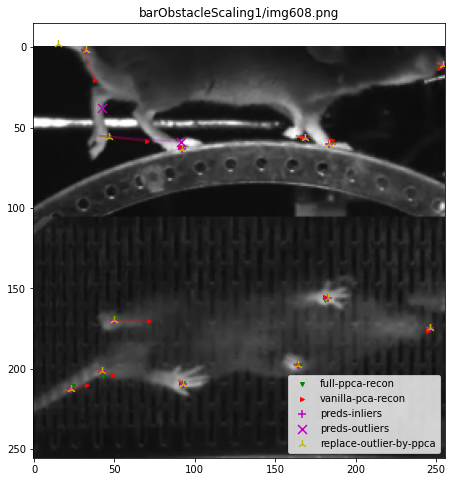

In [250]:
nan_outputs = torch.isnan(out.reshape(-1,2)).any(dim=1)
gt_vector_for_plot = gt_vector.reshape(-1,2).detach().cpu().numpy()
pred_vector_for_plot = pred_vector.reshape(-1,2).detach().cpu().numpy()
full_reconstruction = recon_means.reshape(-1,2).detach().cpu().numpy()
replaced_vector = replaced_pred_vector.reshape(-1,2).detach().cpu().numpy()
vanilla_pca_recon_for_plot = vanilla_pca_recon.T.reshape(-1,2).detach().cpu().numpy()
plt.figure(figsize=(8,8))
plt.imshow(image.resize((256,256)))
#scatter_and_line(gt_vector_for_plot, pred_vector_for_plot, label= "preds", color='blue', marker="+", show_nans=True)
scatter_and_line(gt_vector_for_plot, full_reconstruction, label= "full-ppca-recon", color='g', marker="v", show_nans=False)
scatter_and_line(gt_vector_for_plot, vanilla_pca_recon_for_plot, label= "vanilla-pca-recon", color='r', marker=">", show_nans=False)
scatter_and_line(gt_vector_for_plot[~nan_outputs], pred_vector_for_plot[~nan_outputs], label= "preds-inliers", color='m', marker="+", s=80, show_nans=True)
scatter_and_line(gt_vector_for_plot[nan_outputs], pred_vector_for_plot[nan_outputs], label= "preds-outliers", color='m', marker="x", s=80, show_nans=True)
scatter_and_line(gt_vector_for_plot, replaced_vector, label= "replace-outlier-by-ppca", color='y', marker="2", s= 80, show_nans=True)#scatter_and_line(gt_vector, optimized_vector, label= "postprocessed_wo_conf", color='pink', marker="^", show_nans=False)
#plt.scatter(replaced_vector[nan_outputs,0], replaced_vector[nan_outputs,1], c='brown', label="bla", s=50, zorder=10)
#plt.scatter(pred_vector_for_plot[nan_outputs,0], pred_vector_for_plot[nan_outputs,1], c='orange', marker="X", label="outlier", s=40, zorder=5)
plt.legend(loc="lower right")
plt.title(img_name)
# plt.scatter(pred_vector[mask,0], pred_vector[mask,1], c='b', s=10)
# for i in range(gt_vector.shape[0]):
#     if ~np.isnan(gt_vector[i,0]):
#         plt.plot([gt_vector[i,0], pred_vector[i,0]], [gt_vector[i,1], pred_vector[i,1]], c='b', alpha=0.5)

        

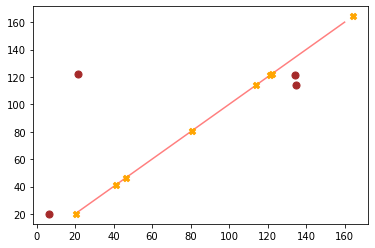

In [87]:

plt.scatter(pred_vector_for_plot[nan_outputs,0], replaced_vector[nan_outputs,0], c='orange', marker="X", label="outlier", s=40, zorder=5)
plt.scatter(pred_vector_for_plot[nan_outputs,1], replaced_vector[nan_outputs,1], c='orange', marker="X", label="outlier", s=40, zorder=5)
plt.scatter(full_reconstruction[nan_outputs,0], replaced_vector[nan_outputs,0], c='brown', label="bla", s=50, zorder=10)
plt.plot([20,160], [20,160], c='r', alpha=0.5)

In [85]:
np.allclose(pred_vector, replaced_vector.reshape(-1))

True

In [86]:
recon_means.shape

torch.Size([28, 1])

In [28]:
print(out)
print(gt_vector.reshape(-1))
print(recon_means.reshape(-1))

tensor([ 78.1865,  68.1775,      nan,      nan, 200.3062,  69.7655,  20.2368,
         79.9506,      nan,      nan,      nan,      nan, 254.5684,  16.8133,
         79.3290, 167.4362,      nan,      nan, 193.3530, 192.3389,  26.4306,
        213.2161,  30.4380, 210.9151,  17.3412, 231.3106, 246.5822, 178.1258])
[ 76.18271722  67.13585223 112.93737374  39.28275862 198.27318419
  68.47239768  19.02568524  78.08198645          nan          nan
          nan          nan 251.01355341  14.81399566  77.61457008
 165.59756831 119.3000701  163.01423622 192.2087649  190.44347303
  24.74578488 211.97743458  29.06409119 209.49593744  16.06889282
 229.57246459 245.13809944 176.99872458]
tensor([ 78.2525,  67.7324, 134.5105,  55.0511, 199.5848,  68.4015,  19.8419,
         79.4270,  21.4343,  24.8178,   6.2240,  31.5402, 251.1171,  15.9743,
         78.8972, 166.1827, 134.2896, 149.4616, 194.2566, 191.9961,  27.0622,
        213.1331,  32.4971, 213.7689,  16.4312, 228.9037, 245.1370, 178.8208])


In [19]:
gt_vector

tensor([ 76.1827,  67.1359, 112.9374,  39.2828, 198.2732,  68.4724,  19.0257,
         78.0820,      nan,      nan,      nan,      nan, 251.0136,  14.8140,
         77.6146, 165.5976, 119.3001, 163.0142, 192.2088, 190.4435,  24.7458,
        211.9774,  29.0641, 209.4959,  16.0689, 229.5725, 245.1381, 176.9987],
       dtype=torch.float64)

In [20]:
# plot_single_removal_heatmap(all_norms, list(included_keypoint_names), is_missing_from_gt=is_missing, conf_below_thresh=conf_below_thresh)

# PPCA

In [14]:
from lightning_pose.utils.pca import LinearGaussian
# initialize an instance

lgssm = LinearGaussian(loss_type="pca_singleview",
    error_metric="reprojection_error",
    data_module=data_module,
    components_to_keep=0.99,
    empirical_epsilon_percentile=1.0,
    columns_for_singleview_pca=cfg.data.columns_for_singleview_pca,
    parametrization="Bishop"
)

Results of running PCA (pca_singleview) on keypoints:
Kept 14/28 components, and found:
Explained variance ratio: [0.354 0.247 0.17  0.063 0.056 0.031 0.02  0.015 0.008 0.008 0.008 0.005
 0.004 0.003 0.002 0.001 0.001 0.001 0.001 0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]
Variance explained by 14 components: 0.992


In [15]:
eval_cond = "train"
inds_to_use = pred_df[(pred_df["set"]==eval_cond).to_numpy()].index.values
img_index = 9
img_name = csv_data.iloc[inds_to_use[img_index],0]
pred_vector = keypoints_pred[inds_to_use[img_index],:]
gt_vector = keypoints_gt[inds_to_use[img_index],:]
conf_vector = confidences[inds_to_use[img_index],:]
file_name = os.path.join(cfg.data.data_dir, img_name)
assert os.path.exists(file_name)
        # if 1 color channel, change to 3.
image = Image.open(file_name).convert("RGB")

In [16]:
pred_vector

tensor([ 78.1865,  68.1775, 113.9567,  41.0158, 200.3062,  69.7655,  20.2368,
         79.9506, 122.1153,  46.3869,  20.2616,  80.7122, 254.5684,  16.8133,
         79.3290, 167.4362, 121.0823, 164.3111, 193.3530, 192.3389,  26.4306,
        213.2161,  30.4380, 210.9151,  17.3412, 231.3106, 246.5822, 178.1258],
       dtype=torch.float64)

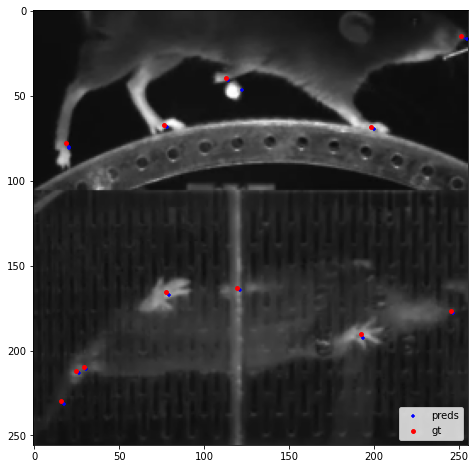

In [17]:
plt.figure(figsize=(8,8))
plt.imshow(image.resize((256,256)))
# mask = ~np.isnan(gt_vector[:,0])
gt_reshaped_vec = gt_vector.detach().cpu().numpy().reshape(-1,2)
pred_reshaped_vec = pred_vector.detach().cpu().numpy().reshape(-1,2)
scatter_and_line(gt_reshaped_vec, pred_reshaped_vec, label= "preds", color='b', marker="+", show_nans=True)
plt.scatter(gt_reshaped_vec[:,0], gt_reshaped_vec[:,1], c='r', label="gt", s=15, zorder=10)
plt.legend(loc="lower right")


In [19]:
# now mask one of the pred_keypoints
inds_to_remove = torch.isnan(gt_vector) #[2,3]
cloned_pred_vector = pred_vector.clone()
cloned_pred_vector[inds_to_remove] = torch.nan

In [20]:
# reconstruct with missing data
reconstruction = lgssm.reconstruct(cloned_pred_vector.float().unsqueeze(-1))

In [21]:
# reconstruct with full data
vanilla_pca_reconstruction = lgssm.reproject(pred_vector.reshape(1,-1).float())

In [22]:
def thresh_by_confidence(preds, confs, thresh):
    mask = confs < thresh
    reshaped_preds = preds.reshape(-1,2)
    reshaped_preds[mask, :] = torch.nan
    return reshaped_preds.reshape(-1)

In [23]:
# make your life easy, start by thresholding by confidence
thresh_by_confidence(pred_vector, conf_vector, 0.06)

tensor([ 78.1865,  68.1775, 113.9567,  41.0158, 200.3062,  69.7655,  20.2368,
         79.9506, 122.1153,  46.3869,      nan,      nan, 254.5684,  16.8133,
         79.3290, 167.4362, 121.0823, 164.3111, 193.3530, 192.3389,  26.4306,
        213.2161,  30.4380, 210.9151,  17.3412, 231.3106, 246.5822, 178.1258],
       dtype=torch.float64)

In [18]:
@typechecked
def loo_reconstruction(pred_vector: TensorType["num_keypoints"]) -> List[TensorType["num_keypoints"]]:
    pred_reshaped = pred_vector.clone().reshape(-1,2)
    recon_results = []
    # loop over all the keypoints
    for i in range(pred_reshaped.shape[0]):
        temp_preds = pred_reshaped.clone()
        if temp_preds[i,:].isnan().any():
            # if it's already a nan from previous iteration, skip
            recon_result = torch.ones((pred_vector.shape[0]))*torch.nan
            recon_results.append(recon_result)
        else:
            # remove keypoint from the prediction vector
            temp_preds[i,:] = torch.nan
            # reconstruct with missing data
            recon_result = lgssm.reconstruct(temp_preds.reshape(-1,1))
            # add the mean reconstruction to the list
            recon_results.append(recon_result["reconstruction"][0].reshape(-1))
    return recon_results


In [19]:
@typechecked
def compute_norms(pred_vector: TensorType["num_keypoints_times_two"], recon_list: List[TensorType["num_keypoints_times_two"]]) -> TensorType["num_keypoints", "num_keypoints"]:
    # check how much each point moved
    norms_list = []
    for i in range(len(recon_list)):
        recons_temp = recon_list[i]
        pred_reshaped = pred_vector.clone().reshape(-1,2)
        recons_temp_reshaped = recons_temp.reshape(-1,2)
        norms = torch.linalg.norm(pred_reshaped - recons_temp_reshaped, dim=1)
        norms_list.append(norms.unsqueeze(-1))
    all_norms = torch.cat(norms_list, dim=-1)
    return all_norms

In [20]:
from typing import Tuple
def find_max_norm(all_norms: TensorType["num_keypoints", "num_keypoints"], included_keypoint_names: List[str]) -> Tuple[TensorType[()], int, str]:
    # get diags of all_norms
    diag_norms = all_norms.diag()
    # get the max norm ind
    max_norm_ind = torch.argmax(diag_norms)
    # get the max norm
    max_norm = diag_norms[max_norm_ind]
    # get the keypoint name
    max_norm_name = included_keypoint_names[max_norm_ind]
    return max_norm, max_norm_ind, max_norm_name

In [33]:
counter = 0
while True:
    counter += 1
    print(f"Iteration {counter}")
    if counter > 8:
        break


Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9


In [28]:
@typechecked
def iterative_reconstruction(pred_vector: TensorType["num_keypoints_times_two"], norm_change_thresh: float, included_keypoint_names: List[str]) -> TensorType["num_keypoints_times_two"]:
    # outer loop:
    preds = pred_vector.clone()
    while True:
        print("iteration")
        # get the reconstruction results
        recon_list = loo_reconstruction(preds)
        # compute the norms
        norms = compute_norms(preds, recon_list)
        # find the maximum norm change
        max_norm, max_norm_ind, max_norm_name = find_max_norm(norms, included_keypoint_names)
        print(f"max_norm: {max_norm}")
        print(f"max_norm_ind: {max_norm_ind}")
        print(f"max_norm_name: {max_norm_name}")
        # if the max norm is less than the threshold, break
        if max_norm < norm_change_thresh:
            print("norm is small enough, breaking")
            break
        else:
            # remove the keypoint and continue
            preds = preds.reshape(-1,2)
            preds[max_norm_ind,:] = torch.nan
            preds = preds.reshape(-1)
        
        return preds

In [29]:
pred_vector

tensor([ 78.1865,  68.1775, 113.9567,  41.0158, 200.3062,  69.7655,  20.2368,
         79.9506, 122.1153,  46.3869,  20.2616,  80.7122, 254.5684,  16.8133,
         79.3290, 167.4362, 121.0823, 164.3111, 193.3530, 192.3389,  26.4306,
        213.2161,  30.4380, 210.9151,  17.3412, 231.3106, 246.5822, 178.1258],
       dtype=torch.float64)

In [30]:
included_keypoint_names = np.array(keypoint_names)[cfg.data.columns_for_singleview_pca]
included_keypoint_names

array(['paw1LH_top', 'paw2LF_top', 'paw3RF_top', 'paw4RH_top',
       'tailBase_top', 'tailMid_top', 'nose_top', 'paw1LH_bot',
       'paw2LF_bot', 'paw3RF_bot', 'paw4RH_bot', 'tailBase_bot',
       'tailMid_bot', 'nose_bot'], dtype='<U12')

In [31]:
out = iterative_reconstruction(pred_vector.float(), 10.0, list(included_keypoint_names))

iteration
max_norm: 96.8585433959961
max_norm_ind: 4
max_norm_name: tailBase_top


In [26]:
out

tensor([ 78.1865,  68.1775, 113.9567,  41.0158, 200.3062,  69.7655,  20.2368,
         79.9506,      nan,      nan,  20.2616,  80.7122, 254.5684,  16.8133,
         79.3290, 167.4362, 121.0823, 164.3111, 193.3530, 192.3389,  26.4306,
        213.2161,  30.4380, 210.9151,  17.3412, 231.3106, 246.5822, 178.1258])

In [267]:
compute_norms(pred_vector.float(), loo_reconstruction(pred_vector.float()))

tensor([[ 9.8828,  3.6550,  2.8367,  2.6764,  2.5959,  2.5160,  2.6743,  4.0642,
          3.9669,  2.3236,  3.9785,  3.5564,  1.6675,  2.6721],
        [14.7926, 33.4354, 12.8517, 15.5817, 12.1405, 13.8348, 14.2812, 15.1036,
          4.1283,  9.2640,  3.9535, 15.5791, 15.0401, 14.3444],
        [ 3.7541,  0.9274, 17.3900,  4.0225,  4.8026,  3.7230,  3.7786,  3.7679,
          0.1702,  1.4586,  2.1472,  3.5478,  2.8677,  3.5663],
        [ 2.0892,  4.5384,  2.9958, 16.2709,  2.7091,  1.5147,  2.2793,  2.0453,
          4.6151,  3.3521,  5.4390,  3.0594,  1.0476,  2.2161],
        [76.4188, 76.0574, 77.0403, 76.0458, 96.8585, 74.4561, 76.7897, 76.5770,
         76.6059, 74.9281, 69.9748, 70.6748, 65.8266, 76.8143],
        [ 9.1798,  9.1268, 10.0406,  8.6992, 11.2584, 18.4458,  9.7675,  9.7409,
         10.3298,  9.3734, 11.2141, 15.7192, 22.1613,  9.7403],
        [ 3.8565,  3.3334,  5.0895,  4.2156,  3.5147,  3.8997,  3.7964,  3.8174,
          4.0054,  4.7734,  3.4315,  4.0124,  4.0

In [261]:
recon_list = loo_reconstruction(pred_vector.float())
for i in range(len(recon_list)):
    # assert no nans
    assert torch.all(~torch.isnan(recon_list[i]))

In [246]:
# check how much each point moved
norms_list = []
for i in range(len(recon_list)):
    recons_temp = recon_list[i]
    pred_reshaped = pred_vector.clone().reshape(-1,2)
    recons_temp_reshaped = recons_temp.reshape(-1,2)
    norms = torch.linalg.norm(pred_reshaped - recons_temp_reshaped, dim=1)
    norms_list.append(norms.unsqueeze(-1))
all_norms = torch.cat(norms_list, dim=-1)

In [249]:
print(conf_vector)
conf_below_thresh = conf_vector < 0.06
is_missing = torch.isnan(gt_vector.reshape(-1,2)).any(dim=1)
print(is_missing)
print(torch.where(is_missing)[0])
print(all_norms.diag())

[0.21961188 0.27701142 0.19017968 0.19645143 0.21549116 0.05381511
 0.31984565 0.19924848 0.21228179 0.21643309 0.23010026 0.21373843
 0.18933704 0.20828708]
tensor([False, False, False, False,  True,  True, False, False, False, False,
        False, False, False, False])
tensor([4, 5])
tensor([ 9.8828, 33.4354, 17.3900, 16.2709, 96.8585, 18.4458,  3.7964,  7.0591,
        34.0795, 41.2710, 76.9202, 30.1940, 49.5854,  1.4689],
       dtype=torch.float64)


In [251]:
# find the keypoint with the highest norm
diag_norms = all_norms.diag()
max_norm_ind = torch.argmax(diag_norms)
max_norm_name = included_keypoint_names[max_norm_ind]
print(int(max_norm_ind), '--', max_norm_name)
# we will mask that norm and re do the procedure

4 -- tailBase_top


In [253]:
# do the loo procedure again, this time with the max norm masked
new_preds = pred_vector.clone().reshape(-1,2)
new_preds[max_norm_ind,:] = torch.nan
recon_list = loo_reconstruction(new_preds.float().reshape(-1))

In [256]:
# check how much each point moved
norms_list = []
for i in range(len(recon_list)):
    recons_temp = recon_list[i]
    pred_reshaped = new_preds.clone().reshape(-1,2)
    recons_temp_reshaped = recons_temp.reshape(-1,2)
    norms = torch.linalg.norm(new_preds - recons_temp_reshaped, dim=1)
    norms_list.append(norms.unsqueeze(-1))
all_norms = torch.cat(norms_list, dim=-1)

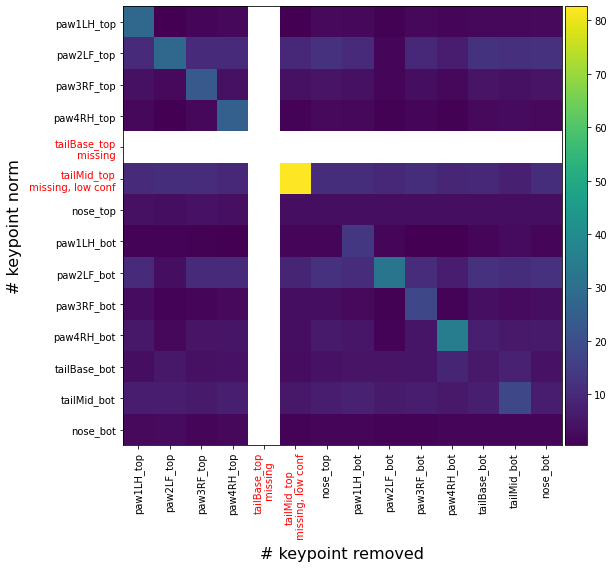

In [257]:
plot_single_removal_heatmap(all_norms, list(included_keypoint_names), is_missing_from_gt=is_missing, conf_below_thresh=conf_below_thresh)

In [77]:
all_norms.diag().shape

torch.Size([14])

In [43]:
# we wanna determine which keypoints moved the most
norms

tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

In [ ]:
# iteratively remove keypoints and reconstruct 
# now mask one of the pred_keypoints
inds_to_remove = torch.isnan(gt_vector) #[2,3]
cloned_pred_vector = pred_vector.clone()
cloned_pred_vector[inds_to_remove] = torch.nan

Text(0.5, 1.0, 'barObstacleScaling1/img157.png')

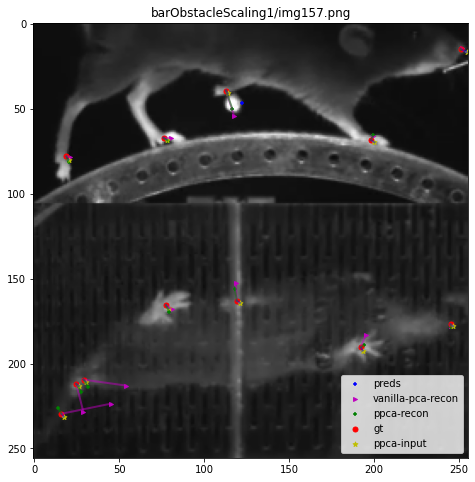

In [24]:
# mask = ~np.isnan(gt_vector[:,0])
# organize the keypoints for plotting
gt_reshaped_vec = gt_vector.detach().cpu().numpy().reshape(-1,2)
pred_reshaped_vec = pred_vector.detach().cpu().numpy().reshape(-1,2)
recon_reshaped_vec = reconstruction["reconstruction"][0].detach().cpu().numpy().reshape(-1,2)
cloned_reshaped_vec = cloned_pred_vector.detach().cpu().numpy().reshape(-1,2)
vanilla_pca_recon_vec = vanilla_pca_reconstruction.detach().cpu().numpy().reshape(-1,2)

# start plotting
plt.figure(figsize=(8,8))
plt.imshow(image.resize((256,256)))
scatter_and_line(gt_reshaped_vec, pred_reshaped_vec, label= "preds", color='b', marker="+", show_nans=True)
scatter_and_line(gt_reshaped_vec, vanilla_pca_recon_vec, label= "vanilla-pca-recon", color='m', marker=">", show_nans=False)
scatter_and_line(gt_reshaped_vec, recon_reshaped_vec, label= "ppca-recon", color='g', marker="+", show_nans=False)
plt.scatter(gt_reshaped_vec[:,0], gt_reshaped_vec[:,1], c='r', label="gt", s=25, zorder=2)
plt.scatter(cloned_reshaped_vec[:,0], cloned_reshaped_vec[:,1], marker = "*", c='y', label="ppca-input", s=25, zorder=2)
plt.legend(loc="lower right")
plt.title(img_name)

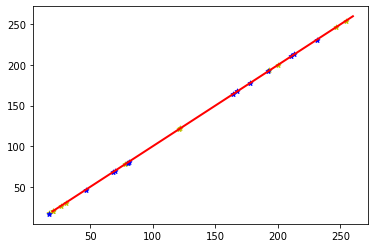

In [75]:
plt.plot([20,260], [20,260], c='r', linewidth=2.0)
plt.scatter(cloned_reshaped_vec[:,0], pred_reshaped_vec[:,0], marker = "*", c='y', label="ppca-input", s=25, zorder=2)
plt.scatter(cloned_reshaped_vec[:,1], pred_reshaped_vec[:,1], marker = "*", c='b', label="ppca-input", s=25, zorder=2)

In [89]:
torch.isnan(gt_vector)

tensor([False, False, False, False, False, False, False, False,  True,  True,
         True,  True, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False])

## CVXPY version
* use norm on desired axis/dims. 
* reshape to go between per bodypart and per frame
* have to reshape differently just to be able to work with 2d mats always and not tensors
* 2d keypoints can be treated independently for the objective
* we just have to reshape them back to num_frames x num_keypoints for the constraints.

In [13]:
from lightning_pose.postprocess.cvxpy_optim import PostProcessorCVXPY

In [14]:
# convert pca params to numpy
pca_param_np = {}
for p_name, p_val in pca_loss.pca.parameters.items():
    if isinstance(p_val, torch.Tensor):
        pca_param_np[p_name] = p_val.detach().cpu().numpy()
    else:
        pca_param_np[p_name] = p_val

In [15]:
confidences = confidences[:, model_cfg.data.columns_for_singleview_pca]

In [16]:
confidences.reshape(-1).shape

(14630,)

In [17]:
# confidences are not used for now. 
# and we're pushing gt keypoints
post_processor = PostProcessorCVXPY(keypoints_preds=keypoints_pred.detach().cpu().numpy(), \
    confidences=None, pca_param_np=pca_param_np)
post_processor2 = PostProcessorCVXPY(keypoints_preds=keypoints_pred.detach().cpu().numpy(), \
    confidences=confidences, pca_param_np=pca_param_np)

In [18]:
prob = post_processor.build_problem()
prob2 = post_processor2.build_problem()

In [19]:
prob.solve()
prob2.solve()

4608.519194593351

In [20]:
pca_loss.pca.data_arr.shape

torch.Size([529, 28])

In [21]:
def clean_any_nans(data: torch.Tensor, dim: int) -> torch.Tensor:
    """Remove samples from a data array that contain nans."""
    # currently supports only 2D arrays
    nan_bool = (
        torch.sum(torch.isnan(data), dim=dim) > 0
    )  # e.g., when dim == 0, those columns (keypoints) that have >0 nans
    no_nan_inds = np.where(~nan_bool)[0]
    if dim == 0:
        clean_data= data[:, ~nan_bool]
    elif dim == 1:
        clean_data= data[~nan_bool]
    return clean_data, no_nan_inds


In [47]:
keypoints_gt.shape

torch.Size([1045, 28])

In [22]:
clean_data, no_nan_inds = clean_any_nans(keypoints_gt, dim=1)

In [23]:
reprojected_gt_good = post_processor.reproject_cvxpy(clean_data)
reprojected_gt_good.shape

torch.Size([654, 28])

In [25]:
reprojected_gt = np.zeros_like(keypoints_gt)*np.nan
reprojected_gt[no_nan_inds, :] = reprojected_gt_good
reprojected_gt.shape

(1045, 28)

In [33]:
reprojected_preds = post_processor.reproject_cvxpy(keypoints_pred)

In [34]:
# need to reshape those arrays, save them in new names, and plot on image
optimized_keypoints = post_processor.x.value.reshape(keypoints_pred.shape)
optimized_keypoints_reshaped = optimized_keypoints.reshape(optimized_keypoints.shape[0], -1, 2)
optimized_keypoints2 = post_processor2.x.value.reshape(keypoints_pred.shape)
optimized_keypoints_reshaped2 = optimized_keypoints2.reshape(optimized_keypoints2.shape[0], -1, 2)
keypoints_gt_reshaped = keypoints_gt.reshape(keypoints_gt.shape[0], -1, 2)
keypoints_pred_reshaped = keypoints_pred.reshape(keypoints_pred.shape[0], -1, 2)
reprojected_gt_reshaped = reprojected_gt.reshape(reprojected_gt.shape[0], -1, 2)
reprojected_preds_reshaped = reprojected_preds.reshape(reprojected_preds.shape[0], -1, 2)

In [35]:
eval_cond = "test"
inds_to_use = pred_df[(pred_df["set"]==eval_cond).to_numpy()].index.values

In [37]:
print(optimized_keypoints_reshaped.shape)
print(optimized_keypoints_reshaped2.shape)
print(keypoints_gt_reshaped.shape)
print(keypoints_pred_reshaped.shape)
print(reprojected_gt_reshaped.shape)
print(reprojected_preds_reshaped.shape)

(1045, 14, 2)
(1045, 14, 2)
torch.Size([1045, 14, 2])
torch.Size([1045, 14, 2])
(1045, 14, 2)
torch.Size([1045, 14, 2])


In [38]:
img_index = 20
img_name = csv_data.iloc[inds_to_use[img_index],0]
file_name = os.path.join(cfg.data.data_dir, img_name)
assert os.path.exists(file_name)
        # if 1 color channel, change to 3.
image = Image.open(file_name).convert("RGB")

In [39]:
assert ~np.any(confidences<0.0)

Text(0.5, 1.0, 'barObstacleScaling1/img235.png')

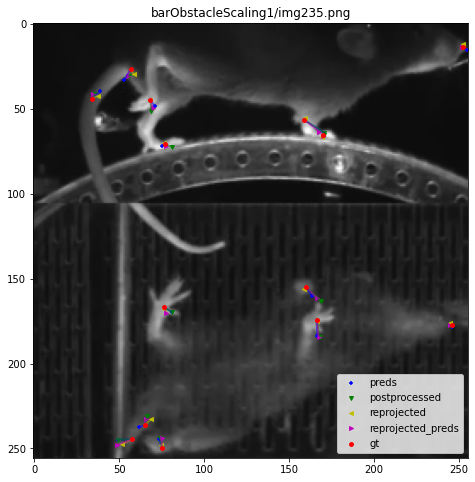

In [40]:
gt_vector = keypoints_gt_reshaped[inds_to_use[img_index],:,:].detach().cpu().numpy()
pred_vector = keypoints_pred_reshaped[inds_to_use[img_index],:,:].detach().cpu().numpy()
optimized_vector = optimized_keypoints_reshaped[inds_to_use[img_index],:,:]
optimized_vector2 = optimized_keypoints_reshaped2[inds_to_use[img_index],:,:]
reprojected_vector = reprojected_gt_reshaped[inds_to_use[img_index],:,:]
reprojected_vector2 = reprojected_preds_reshaped[inds_to_use[img_index],:,:]
plt.figure(figsize=(8,8))
plt.imshow(image.resize((256,256)))
mask = ~np.isnan(gt_vector[:,0])
scatter_and_line(gt_vector, pred_vector, label= "preds", color='b', marker="+", show_nans=False)
scatter_and_line(gt_vector, optimized_vector2, label= "postprocessed", color='g', marker="v", show_nans=False)
scatter_and_line(gt_vector, reprojected_vector, label= "reprojected_gt", color='y', marker="<", show_nans=False)
scatter_and_line(gt_vector, reprojected_vector2, label= "reprojected_preds", color='m', marker=">", show_nans=False)
#scatter_and_line(gt_vector, optimized_vector, label= "postprocessed_wo_conf", color='pink', marker="^", show_nans=False)
plt.scatter(gt_vector[:,0], gt_vector[:,1], c='r', label="gt", s=15, zorder=10)
plt.legend(loc="lower right")
plt.title(img_name)
# plt.scatter(pred_vector[mask,0], pred_vector[mask,1], c='b', s=10)
# for i in range(gt_vector.shape[0]):
#     if ~np.isnan(gt_vector[i,0]):
#         plt.plot([gt_vector[i,0], pred_vector[i,0]], [gt_vector[i,1], pred_vector[i,1]], c='b', alpha=0.5)

        

In [101]:
keypoints_gt_reshaped.shape

torch.Size([1045, 14, 2])

In [42]:
x_fat = cp.reshape(post_processor2.x.T, shape=(post_processor2.orig_shape[1], post_processor2.orig_shape[0])).T
reconstruction = post_processor2.reproject_cvxpy(x=x_fat)
recon_err = post_processor2.compute_recon_error(x=x_fat, reconstruction=reconstruction)


In [79]:
less_than = recon_err.value < pca_param_np["epsilon"]
equal = np.abs(recon_err.value - pca_param_np["epsilon"]) < 1e-8
assert np.all(less_than | equal)
#assert(np.all((recon_err.value < pca_param_np["epsilon"]) or (recon_err.value == pca_param_np["epsilon"])))

In [44]:
preds_fat = cp.reshape(post_processor2.keypoints_preds_2d.T, shape=(post_processor2.orig_shape[1], post_processor2.orig_shape[0])).T
preds_reconstruction = post_processor2.reproject_cvxpy(x=preds_fat)
preds_recon_err = post_processor2.compute_recon_error(x=preds_fat, reconstruction=preds_reconstruction)


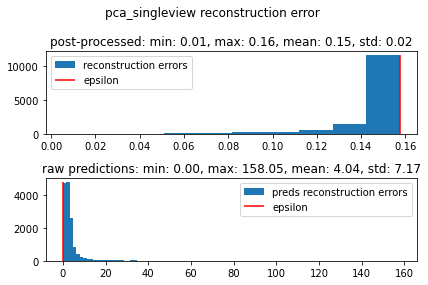

In [71]:
# compute reprojections and assert all smaller than eps
plt.suptitle("pca_singleview reconstruction error")
plt.subplot(2,1,1)
h1 = plt.hist(recon_err.value, density=False, label="reconstruction errors")
plt.vlines(x=pca_param_np["epsilon"], ymin=0, ymax=np.max(h1[0]), color="r", label="epsilon")
plt.legend()
plt.title("post-processed: min: {:.2f}, max: {:.2f}, mean: {:.2f}, std: {:.2f}".format(np.min(recon_err.value), np.max(recon_err.value), np.mean(recon_err.value), np.std(recon_err.value)))
plt.subplot(2,1,2)
h2 = plt.hist(preds_recon_err.value, bins=100, density=False, label="preds reconstruction errors")
plt.vlines(x=pca_param_np["epsilon"], ymin=0, ymax=np.max(h2[0]), color="r", label="epsilon")
plt.legend()
plt.title("raw predictions: min: {:.2f}, max: {:.2f}, mean: {:.2f}, std: {:.2f}".format(np.min(preds_recon_err.value), np.max(preds_recon_err.value), np.mean(preds_recon_err.value), np.std(preds_recon_err.value)))
plt.tight_layout()

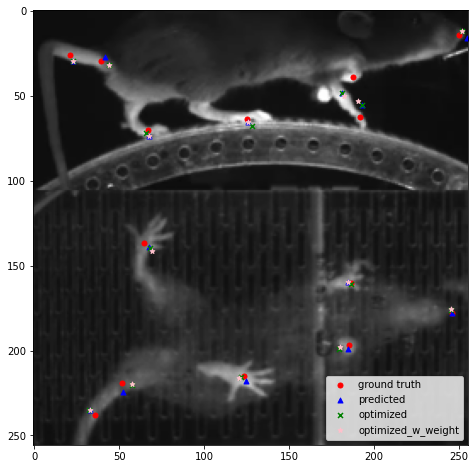

In [62]:
plt.figure(figsize=(8,8))
plt.imshow(image.resize((256,256)))
plt.scatter(keypoints_gt_reshaped[inds_to_use[img_index],:,0], keypoints_gt_reshaped[inds_to_use[img_index],:,1], s=25, c="r", label="ground truth", marker="o")
plt.scatter(keypoints_pred_reshaped[inds_to_use[img_index],:,0], keypoints_pred_reshaped[inds_to_use[img_index],:,1], s=25, c="b", label="predicted", marker="^")
plt.scatter(optimized_keypoints_reshaped[inds_to_use[img_index],:,0], optimized_keypoints_reshaped[inds_to_use[img_index],:,1], s=25, c="g", label="optimized", marker="x")
plt.scatter(optimized_keypoints_reshaped2[inds_to_use[img_index],:,0], optimized_keypoints_reshaped2[inds_to_use[img_index],:,1], s=25, c="pink", label="optimized_w_weight", marker="*")
plt.legend(loc="lower right")

### old stuff below

In [18]:
post_processor.pca_mean.shape

(28,)

In [13]:
test_arr = np.array([[0., 1., 0., 2], [0., 10., 0., 20.], [0., 100., 0., 200.]])
print(test_arr)
test_arr1 = test_arr.reshape(test_arr.shape[0], -1, 2)
test_arr_2 = test_arr.reshape(-1,2)
# can reshape directly to test_arr_2
assert(np.allclose(test_arr_2[1,:], test_arr[0, 2:]))
test_arr_3 = test_arr_2.reshape(test_arr.shape)
assert(np.allclose(test_arr_3, test_arr))

[[  0.   1.   0.   2.]
 [  0.  10.   0.  20.]
 [  0. 100.   0. 200.]]


In [49]:
keypoints_pred = keypoints_pred.detach().cpu().numpy()
keypoints_pred_2d = keypoints_pred.reshape(-1, 2) # shape (samples* n_keypoints, 2)
print(keypoints_pred_2d.shape)

AttributeError: 'numpy.ndarray' object has no attribute 'detach'

In [15]:
pca_param_np.keys()

dict_keys(['mean', 'kept_eigenvectors', 'discarded_eigenvectors', 'epsilon'])

In [16]:
from typing import Dict, List, Tuple

In [25]:
def reproject_cvxpy(keypoints, evecs, mean):
    mean = np.tile(mean, (keypoints.shape[0], 1)) # for each sample, repeat mean, to broadcast
    # transform data into low-d space as in scikit learn's _BasePCA.transform()
    # https://github.com/scikit-learn/scikit-learn/blob/37ac6788c9504ee409b75e5e24ff7d86c90c2ffb/sklearn/decomposition/_base.py#L97
    centered_data = keypoints - mean
    low_d_projection = centered_data @ evecs.T

    # project back up to observation space, as in scikit learn's _BasePCA.inverse_transform()
    # https://github.com/scikit-learn/scikit-learn/blob/37ac6788c9504ee409b75e5e24ff7d86c90c2ffb/sklearn/decomposition/_base.py#L125
    reprojection = low_d_projection @ evecs + mean
    return reprojection
    
def build_pca_constraint(x: cp.Variable, keypoints_orig_shape: Tuple[int,int], pca_param_np: Dict[str, np.array]) -> List[cp.constraints.Inequality]:
    # reshape keypoints 
    #shapes = x.shape
    #out = np.prod(shapes)//2
    #test_arr_f = test_arr.T.reshape(2,out, order='F').T # that's what I should do!
    #x = cp.reshape(x.T, shape=(2, out)).T
    x = cp.reshape(x.T, shape=(keypoints_orig_shape[1], keypoints_orig_shape[0])).T
    print(x)
    # transform data into low-d space as in scikit learn's _BasePCA.transform()
    reconstruction = reproject_cvxpy(x, pca_param_np["kept_eigenvectors"], pca_param_np["mean"])
    recon_err = cp.norm(reconstruction - x, p=2, axis=1)
    return [recon_err <= pca_param_np["epsilon"]]

In [26]:
# build_pca_constraint(x=x, keypoints_orig_shape=keypoints_pred.shape, pca_param_np=pca_param_np)

In [48]:
keypoints_pred_2d = keypoints_pred.reshape(-1, 2) # shape (samples* n_keypoints, 2)

x = cp.Variable(keypoints_pred_2d.shape)
print(x)
#x.value = keypoints_pred_2d.detach().cpu().numpy() # doesn't seem to matter
weights = confidences.reshape(keypoints_pred_2d.shape) #np.ones(shape=(keypoints_pred_2d.shape[0],)) # in the future use actual vals

norm = cp.norm(x - keypoints_pred_2d, p=2, axis=1)
# sum the weighted norms over the samples and keypoints
objective = cp.Minimize(cp.sum(cp.multiply(weights, norm)))

constraints = build_pca_constraint(x=x, keypoints_orig_shape=keypoints_pred.shape, pca_param_np=pca_param_np)

prob = cp.Problem(objective, constraints)
print(prob)

print("Optimal value", prob.solve())
print("Optimal var")
print(x.value) # A numpy ndarray.


var84


ValueError: cannot reshape array of size 17765 into shape (14630,2)

In [28]:
print("Optimal value", prob.solve())

Optimal value 123356.9091458245


In [29]:
optimized_keypoints = x.value.reshape(keypoints_pred.shape)

In [30]:
optimized_keypoints.shape

(1045, 28)

In [31]:
pred_df["set"].columns.to_flat_index()
#pred_df[pred_df["set"]=="train"]

Index([('Unnamed: 52_level_1', 'Unnamed: 52_level_2')], dtype='object')

In [32]:
eval_cond = "test"
inds_to_use = pred_df[(pred_df["set"]==eval_cond).to_numpy()].index.values

In [39]:
img_name = csv_data.iloc[inds_to_use[0],0]#["image_name"]
img_name

'barObstacleScaling1/img10.png'

In [33]:
from PIL import Image

In [35]:
keypoints_gt = keypoints_gt.reshape(keypoints_gt.shape[0], -1, 2)
keypoints_pred = keypoints_pred.reshape(keypoints_pred.shape[0], -1, 2)

In [36]:
optimized_keypoints = optimized_keypoints.reshape(optimized_keypoints.shape[0], -1, 2)

In [37]:
print(optimized_keypoints.shape)
print(keypoints_pred.shape)
print(keypoints_gt.shape)

(1045, 14, 2)
(1045, 14, 2)
torch.Size([1045, 14, 2])


In [45]:
img_index = 16
img_name = csv_data.iloc[inds_to_use[img_index],0]
file_name = os.path.join(cfg.data.data_dir, img_name)
assert os.path.exists(file_name)
        # if 1 color channel, change to 3.
image = Image.open(file_name).convert("RGB")


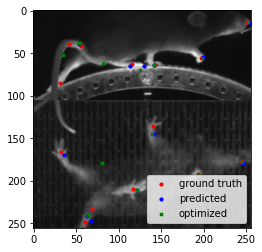

In [46]:
plt.imshow(image.resize((256,256)))
plt.scatter(keypoints_gt[inds_to_use[img_index],:,0], keypoints_gt[inds_to_use[img_index],:,1], s=10, c="r", label="ground truth")
plt.scatter(keypoints_pred[inds_to_use[img_index],:,0], keypoints_pred[inds_to_use[img_index],:,1], s=10, c="b", label="predicted")
plt.scatter(optimized_keypoints[inds_to_use[img_index],:,0], optimized_keypoints[inds_to_use[img_index],:,1], s=10, c="g", label="optimized", marker="x")
plt.legend(loc="lower right")
#plt.savefig('/home/jovyan/figs/first_cvxpy_optim.png')


In [26]:
pred_df["set"].index.values
#pred_df[pred_df.set=="test"]

array([   0,    1,    2, ..., 1042, 1043, 1044])

In [21]:
from lightning_pose.data.utils import DataExtractor

In [22]:
keypoints_tensor, images_tensor = DataExtractor(data_module=data_module, cond="test", extract_images=True)()

In [24]:
keypoints_tensor.shape

torch.Size([105, 34])

In [24]:
(2,3)

AttributeError: 'tuple' object has no attribute 'T'

In [102]:
# test reshaping
test_arr = np.array([[0., 1., 0., 2], [0., 10., 0., 20.], [0., 100., 0., 200.]])
print(test_arr)
test_arr1 = test_arr.reshape(test_arr.shape[0], -1, 2)
test_arr_2 = test_arr.reshape(-1,2)
# can reshape directly to test_arr_2
assert(np.allclose(test_arr_2[1,:], test_arr[0, 2:]))
test_arr_3 = test_arr_2.reshape(test_arr.shape)
assert(np.allclose(test_arr_3, test_arr))

[[  0.   1.   0.   2.]
 [  0.  10.   0.  20.]
 [  0. 100.   0. 200.]]


In [105]:
norm = cp.norm(test_arr_2, p=2, axis=1)
norm.shape

(6,)

In [106]:
norm.value

array([  1.,   2.,  10.,  20., 100., 200.])

In [109]:
# invert the shape order, have two transposes
cp.reshape(norm.T, shape=(2,3)).T.value

array([[  1.,   2.],
       [ 10.,  20.],
       [100., 200.]])

In [112]:
cp.reshape(test_arr.T, shape=(2,6)).T.value

array([[  0.,   1.],
       [  0.,   2.],
       [  0.,  10.],
       [  0.,  20.],
       [  0., 100.],
       [  0., 200.]])